In [61]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [62]:
df = pd.read_csv('./fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [63]:
x_train = []
y_train = []
x_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        x_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        x_test.append(np.array(k))
        y_test.append(row['emotion'])

In [64]:
x_train = np.array(x_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
x_test = np.array(x_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [65]:
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [66]:
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_train = np.stack((x_train,)*3, axis=4)
x_train = x_train.reshape(x_train.shape[0],48,48,3)
x_test = np.stack((x_test,)*3, axis=4)
x_test = x_test.reshape(x_test.shape[0],48,48,3)

In [67]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (28709, 48, 48, 3) - y_train shape: (28709, 7)
x_test shape: (3589, 48, 48, 3) - y_test shape: (3589, 7)


In [74]:
validation_dataset = (x_test,y_test)

In [48]:
# datagen
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 30,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    )

datagen.fit(x_train)
testgen = ImageDataGenerator(rescale=1./255)

In [49]:
batch_size = 32
train_flow = datagen.flow(x_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(x_test, y_test, batch_size=batch_size)

In [76]:
image_size = 120
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.30),
        layers.RandomZoom(
           height_factor=0.2, width_factor=0.2
        ),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [81]:
#model
from keras.applications import VGG19, VGG16, Xception, ResNet50V2, ResNet152V2, ResNet50

base_model = keras.applications.ResNet50V2(
#base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    #weights = None,  # Load weights pre-trained on ImageNet.
    #input shape for resnet
    input_shape=(120, 120, 3),
    #input shape for vgg19
    #input_shape=(48, 48, 3),
    include_top=False)

In [82]:
base_model.trainable = True
num_classes = 7
inputs = keras.Input(shape=(48, 48, 3))
augmented = data_augmentation(inputs)
x = base_model(augmented, training=True)
#for the resnet50 model global pooling used
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [58]:
checkpoint_filepath = "./tmp-cnn/checkpoint-model-ResNet50V2-adam-datagen"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)

In [31]:
batch_size = 32
num_epochs = 100
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6)
    #optimizer = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            #from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    checkpoint_filepath = "./tmp-cnn/checkpoint-model-ResNet50V2-AdamW-pretrained-100epoch-run-2"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    #reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-6, factor=0.75)
    #checkpoint_filepath_prev = "./tmp-cnn/checkpoint-model-ResNet50V2-aug"
    #model.load_weights(checkpoint_filepath)
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=validation_dataset,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history



history = run_experiment(model)


Epoch 1/100
898/898 [==============================] - 211s 228ms/step - loss: 1.4740 - accuracy: 0.4313 - top-5-accuracy: 0.9470 - val_loss: 1.2768 - val_accuracy: 0.5107 - val_top-5-accuracy: 0.9666
Epoch 2/100
898/898 [==============================] - 142s 158ms/step - loss: 1.2501 - accuracy: 0.5243 - top-5-accuracy: 0.9703 - val_loss: 1.1919 - val_accuracy: 0.5483 - val_top-5-accuracy: 0.9769
Epoch 3/100
898/898 [==============================] - 134s 149ms/step - loss: 1.1691 - accuracy: 0.5556 - top-5-accuracy: 0.9779 - val_loss: 1.1550 - val_accuracy: 0.5659 - val_top-5-accuracy: 0.9777
Epoch 4/100
898/898 [==============================] - 132s 148ms/step - loss: 1.1198 - accuracy: 0.5773 - top-5-accuracy: 0.9799 - val_loss: 1.1002 - val_accuracy: 0.5815 - val_top-5-accuracy: 0.9819
Epoch 5/100
898/898 [==============================] - 130s 145ms/step - loss: 1.0808 - accuracy: 0.5949 - top-5-accuracy: 0.9817 - val_loss: 1.0926 - val_accuracy: 0.5946 - val_top-5-accuracy: 0.

Epoch 82/100
898/898 [==============================] - 127s 142ms/step - loss: 0.3031 - accuracy: 0.8886 - top-5-accuracy: 0.9998 - val_loss: 1.3618 - val_accuracy: 0.6656 - val_top-5-accuracy: 0.9824
Epoch 83/100
898/898 [==============================] - 126s 140ms/step - loss: 0.2971 - accuracy: 0.8909 - top-5-accuracy: 0.9998 - val_loss: 1.3576 - val_accuracy: 0.6623 - val_top-5-accuracy: 0.9819
Epoch 84/100
898/898 [==============================] - 125s 139ms/step - loss: 0.3000 - accuracy: 0.8894 - top-5-accuracy: 0.9999 - val_loss: 1.3356 - val_accuracy: 0.6654 - val_top-5-accuracy: 0.9838
Epoch 85/100
898/898 [==============================] - 126s 140ms/step - loss: 0.2843 - accuracy: 0.8962 - top-5-accuracy: 0.9998 - val_loss: 1.3708 - val_accuracy: 0.6673 - val_top-5-accuracy: 0.9850
Epoch 86/100
898/898 [==============================] - 127s 142ms/step - loss: 0.2872 - accuracy: 0.8955 - top-5-accuracy: 0.9998 - val_loss: 1.3762 - val_accuracy: 0.6682 - val_top-5-accurac

In [164]:
model.load_weights(checkpoint_filepath)

In [61]:
print(model.evaluate(test_flow))

113/113 [==============================] - 2s 20ms/step - loss: 1.3620 - accuracy: 0.6539
[1.3620240688323975, 0.6539425849914551]


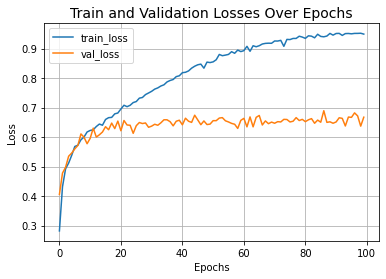

In [137]:
# history for VGG19, accuracy is used but miss typed as loss
plt.plot(history.history["accuracy"], label="train_loss")
plt.plot(history.history['val_accuracy'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

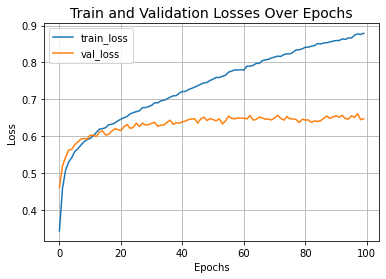

In [60]:
# history for Resnet50, accuracy is used but miss typed as loss
plt.plot(history.history["accuracy"], label="train_loss")
plt.plot(history.history['val_accuracy'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
checkpoint_filepath = "./tmp-cnn/checkpoint-model-vgg-trainable"
model.load_weights(checkpoint_filepath)

In [83]:
checkpoint_filepath = "./tmp-cnn/checkpoint-model-ResNet50V2-AdamW-pretrained-100epoch-run-2"
model.load_weights(checkpoint_filepath)

In [90]:
y_pred = model.predict(x_test)

113/113 [==============================] - 3s 31ms/step


In [91]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[268   7  34  20  84  14  40]
 [  9  35   1   2   7   0   2]
 [ 45   4 239  15 102  42  49]
 [ 24   0   9 779  21  17  45]
 [ 59   2  66  23 397  19  87]
 [  5   0  29  13  16 337  15]
 [ 37   2  26  61  95  12 374]]


In [92]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral'])

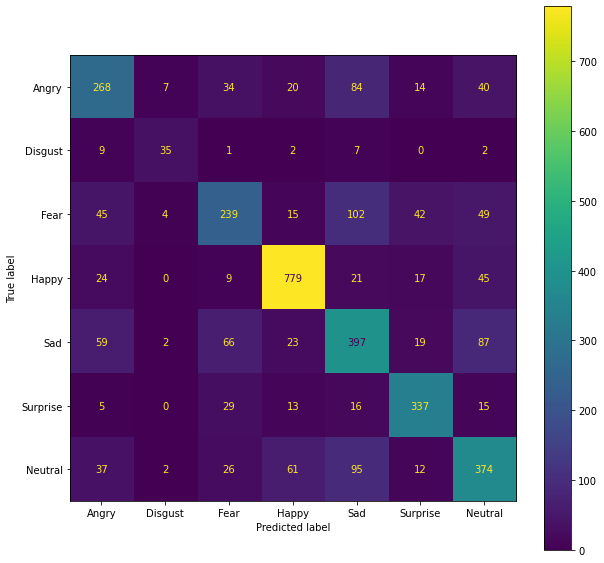

In [93]:
cm_display.plot()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [94]:
from sklearn.metrics import classification_report

In [95]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.60      0.57      0.59       467
           1       0.70      0.62      0.66        56
           2       0.59      0.48      0.53       496
           3       0.85      0.87      0.86       895
           4       0.55      0.61      0.58       653
           5       0.76      0.81      0.79       415
           6       0.61      0.62      0.61       607

    accuracy                           0.68      3589
   macro avg       0.67      0.66      0.66      3589
weighted avg       0.68      0.68      0.67      3589

